# Lista de Exercícios 8

**Aluno**: Vítor Gabriel Reis Caitité

No ano de 2021, a plataforma Kaggle publicou o “Porto Seguro Data Challenge” para que competidores em Data Science pudessem submeter modelos para uma base de dados de classificação (Y = 0,1).Os dados (PortoSeguro.xlsx) contêm um índice de identificação (id), 68 variáveis explicativas e uma variável resposta. Cada linha representa um cliente. Faça uma análise de consistência dos dados e ajuste um modelo de regressão logística para estimar a chance de ocorrência do evento Y = 1. Inclua em suas análises comentários sobre o ajuste do modelo. Faça um relatório sucinto e apresente discussões dos resultados obtidos. Acrescente na sua análise os resultados da curva ROC e a análise da sensibilidade e da especificidade do modelo ajustado. Discuta os resultados.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import *
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, roc_curve, precision_recall_curve
import seaborn as sns

## Leitura do Dataset

In [2]:
dataset = pd.read_csv('~/Documents/UFMG/Doutorado/materias/parametric-and-nonparametric-regression-models/exercise_8/PortoSeguro.csv', header=0, sep=",", engine='python')
dataset.head(5)

# Identificando as colunas que têm mais de 15% de NaNs
cols_to_drop = dataset.columns[dataset.isna().mean() > 0.15]
# Removendo as colunas com mais de 15% de NaNs
dataset = dataset.drop(columns=cols_to_drop)
print(f"Colunas removidas: {cols_to_drop}")

# Removendo linhas que contém NaN:
dataset = dataset.dropna()
dataset

Colunas removidas: Index(['var8', 'var10', 'var59', 'var60', 'var65', 'var66'], dtype='object')


,id,var1,var2,var3,var4,var5,var6,var7,var9,var11,...,var56,var57,var58,var61,var62,var63,var64,var67,var68,y
0,1,18,19.0,2853.0,29442.0,1386,2435.0,35.0,3.0,6498.0,...,0.137,0.833333,0.037822,0.142303,0.056146,0.632694,0.024054,0.132353,0.139706,1
2,30,0,39.0,1019.0,10232.0,678,791.0,16.0,3.0,9739.0,...,0.213,0.451613,0.018639,0.200814,0.051046,0.980827,0.018536,0.382353,0.242647,0
3,43,20,39.0,1751.0,2689.0,8235,1042.0,13.0,1.0,2890.0,...,0.716,0.101075,0.204753,0.352379,0.044301,0.951564,0.023684,0.147059,0.132353,0
4,46,7,44.0,2262.0,29428.0,6031,304.0,16.0,3.0,13541.0,...,0.596,0.101075,0.140394,0.226161,0.059125,0.906155,0.020733,0.455882,0.132353,1
6,69,5,89.0,1906.0,28845.0,9676,64.0,35.0,3.0,15320.0,...,0.014,1.000000,0.007534,0.145790,0.035340,0.867810,0.014831,0.514706,0.224265,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14116,35291,8,110.0,2770.0,32375.0,1406,1095.0,35.0,3.0,30846.0,...,0.366,0.203226,0.135965,0.237818,0.072139,0.799193,0.023594,0.058824,0.121324,0
14117,35294,6,19.0,2242.0,14818.0,4299,2256.0,35.0,3.0,24471.0,...,0.926,0.031183,0.034076,0.179897,0.074473,0.873865,0.016402,0.102941,0.191176,0
14120,35301,27,44.0,1786.0,23761.0,9048,623.0,35.0,3.0,1249.0,...,0.029,1.000000,0.034263,0.203394,0.040697,0.930373,0.009440,0.397059,0.158088,0
14121,35304,4,89.0,210.0,19593.0,3634,2453.0,35.0,1.0,21128.0,...,0.154,0.833333,0.022503,0.381038,0.100384,0.680121,0.041096,0.264706,0.128676,0


## Leitura dos Metadados

In [3]:
metadata = pd.read_csv('~/Documents/UFMG/Doutorado/materias/parametric-and-nonparametric-regression-models/exercise_8/PortoSeguro_metadata.csv', header=0, sep=",", engine='python')
for id in cols_to_drop:
    metadata = metadata[metadata['Variavel cod'] != id]
metadata

,Variavel cod,Variavel tipo
0,id,Qualitativo nominal
1,var1,Qualitativo nominal
2,var2,Qualitativo nominal
3,var3,Qualitativo nominal
4,var4,Qualitativo nominal
...,...,...
63,var63,Quantitativo continua
64,var64,Quantitativo continua
67,var67,Quantitativo discreto
68,var68,Quantitativo discreto


## Pré-processamento

O código abaixo realiza um pré-processamento nos dados categóricos do *dataset* e prepara as variáveis para análise, aplicando técnicas de filtragem, codificação de variáveis e organização do conjunto de dados. Colunas categóricas com baixa frequência foram processadas, e categorias raras (com frequência menor que 5% do tamanho do dataset) foram agrupadas na categoria 'demais'. As variáveis categóricas foram transformadas em colunas one-hot encoding.

In [4]:
dataset = dataset.iloc[:, 1:]
metadata = metadata.iloc[1:,:]

# Definir limite de frequência mínima (5%)
min_percentage = 0.05
min_count = min_percentage * len(dataset)

print("Colunas categóricas:")
for _, vars in metadata.iterrows():
    if vars.iloc[1] == "Qualitativo nominal":
        print(f"{vars.iloc[0]}", end=', ')
        # Contar as ocorrências de cada categoria
        category_counts = dataset[vars.iloc[0]].value_counts()

        # Identificar as categorias que atendem ao critério
        valid_categories = category_counts[category_counts >= min_count].index

        # Checando se existem categorias que atendam ao critério: 
        if len(valid_categories) == 0:
            dataset = dataset.drop([vars.iloc[0]], axis=1)
        else:    
            # Substituir categorias com baixa frequência por "demais"
            dataset['categorias'] = dataset[vars.iloc[0]].apply(lambda x: x if x in valid_categories else 'demais')

            # Criar colunas one-hot encoding
            df_one_hot = pd.get_dummies(dataset['categorias'], prefix=vars.iloc[0], drop_first=True)

            # Remover colunas originais
            dataset = pd.concat([dataset.drop(['categorias', vars.iloc[0]], axis=1), df_one_hot], axis=1)  

# Adicionando a coluna "y" no final
y_col = dataset.pop('y')
dataset['y'] = y_col  
dataset.head(5)

Colunas categóricas:
var1, var2, var3, var4, var5, var6, var7, var9, var11, var12, var13, var14, var15, var16, var17, var18, var19, var20, var21, var22, var23, var28, var29, var30, var31, var33, var34, var35, var36, var37, var38, var39, var41, 

,var24,var25,var26,var27,var32,var40,var42,var43,var44,var45,...,var37_25,var37_demais,var38_8,var38_10,var38_demais,var39_4,var39_demais,var41_3,var41_demais,y
0,0,4,7.0,0,16,9,25,6,1,4,...,False,False,False,False,False,True,False,True,False,1
2,2,1,7.0,0,11,3,23,5,1,0,...,False,False,False,False,False,True,False,True,False,0
3,0,0,1.0,1,8,10,22,10,1,1,...,False,False,False,False,False,True,False,True,False,0
4,2,1,8.0,1,17,5,26,5,1,0,...,False,False,False,False,True,True,False,True,False,1
6,0,1,4.0,0,14,2,24,5,1,0,...,False,False,False,False,False,True,False,True,False,0


## Análise Exploratória

### Matriz de Correlação

A matriz abaixo exibe a correlação entre as variáveis do conjunto de dados.

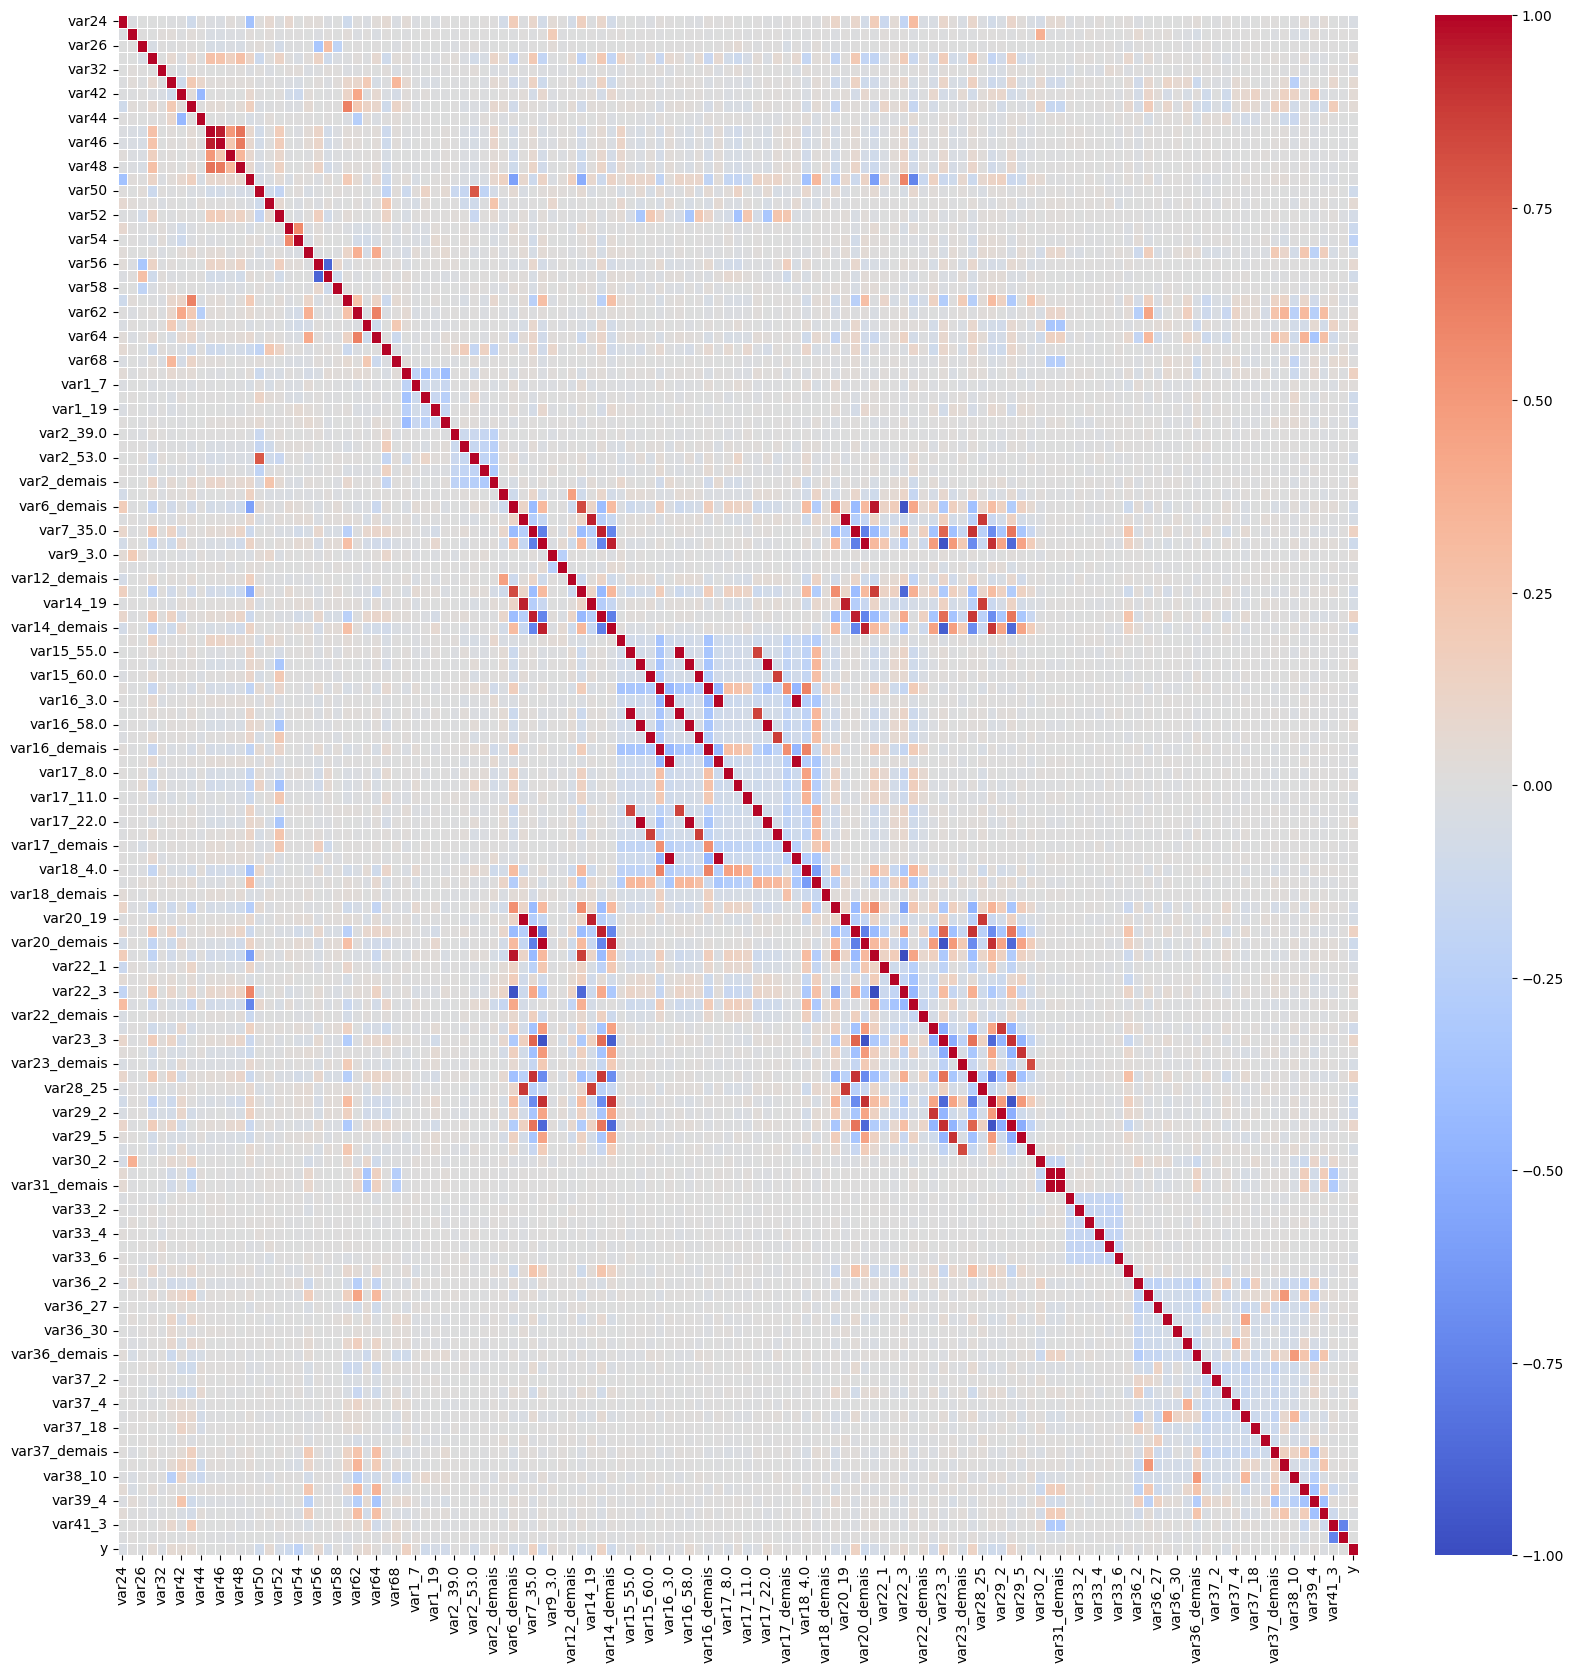

In [5]:
correlation_matrix = dataset.corr()

# Mapa de calor da correlação
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

**Observações:**

    1. Não existe nenhuma correlação forte entre uma variável independente e a variável y.
    2. Foi possível identificar variáveis independentes altamente correlacionadas. A remoção delas pode ser útil  para evitar redundância e multicolinearidade.

In [6]:
# Obter as correlações com a variável 'y'
correlation_with_y = correlation_matrix['y']

# Exibir as variáveis com as maiores correlações com 'y' (excluindo 'y' dela mesma)
sorted_correlation = correlation_with_y.drop('y').sort_values(ascending=False, key=abs)

# Exibir as variáveis mais correlacionadas com 'y'
print(f"As 5 variáveis com maiores correlações com a variável y são:\n{sorted_correlation[:5]}")


As 5 variáveis com maiores correlações com a variável y são:
var54       -0.209027
var1_4       0.146640
var7_35.0    0.138591
var20_26     0.138591
var28_24     0.131507
Name: y, dtype: float64


Os valores acima confirmam que não existe nenhuma variável independente com correlação forte com a variável y.

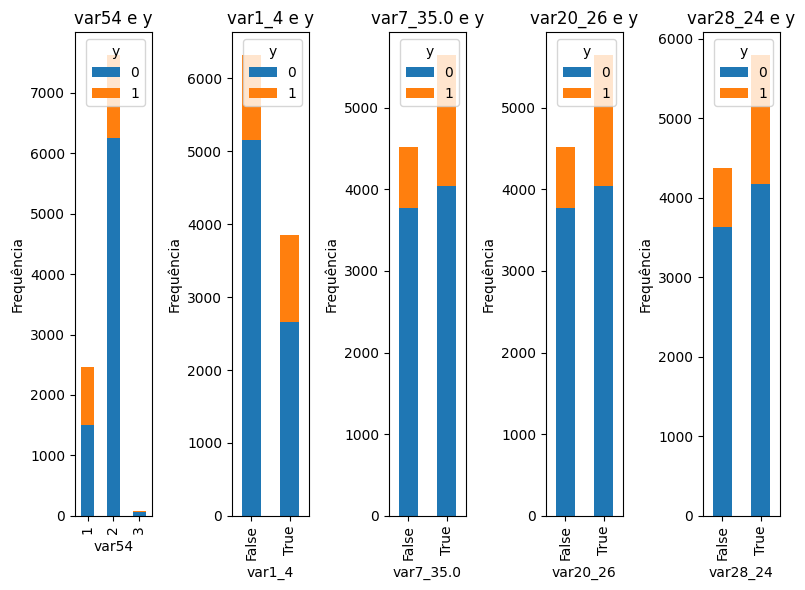

In [7]:
# Definir a estrutura dos subplots (2 linhas, 3 colunas)
fig, axes = plt.subplots(1, 5, figsize=(80, 3))

# Tabela de contingência
col=0
for var in sorted_correlation[:5].index.tolist():
    contingency_table = pd.crosstab(dataset[var], dataset['y'])
    #print(contingency_table)

    contingency_table.plot(kind='bar', stacked=True, figsize=(8, 6), ax=axes[col], label='1')
    axes[col].set_title(f'{var} e y')
    axes[col].set_xlabel(var)
    axes[col].set_ylabel('Frequência')
    axes[col].legend(title='y')
    col += 1

plt.tight_layout()
plt.show()

Mesmo nas variáveis com maior correlação com 'y' não é possível observar uma conexão clara nos gráficos acima, evidenciando novamente ma relação fraca entre as variáveis independentes e 'y'. 

### Remoção de *Features*

As *features* redundantes (com correlação acima de 80% com outras variáveis independentes) foram removidas. Isso é importante para evitar multicolinearidade e permitir os modelos a seguir convergirem.

Features removidas devido à alta correlação: ['var46', 'var57', 'var13_demais', 'var14_19', 'var14_26', 'var14_demais', 'var16_56.0', 'var16_58.0', 'var16_61.0', 'var16_demais', 'var17_3.0', 'var17_20.0', 'var17_22.0', 'var17_23.0', 'var18_3.0', 'var20_19', 'var20_26', 'var20_demais', 'var21_demais', 'var22_3', 'var23_3', 'var28_24', 'var28_25', 'var28_demais', 'var29_2', 'var29_4', 'var29_5', 'var29_demais', 'var31_demais']


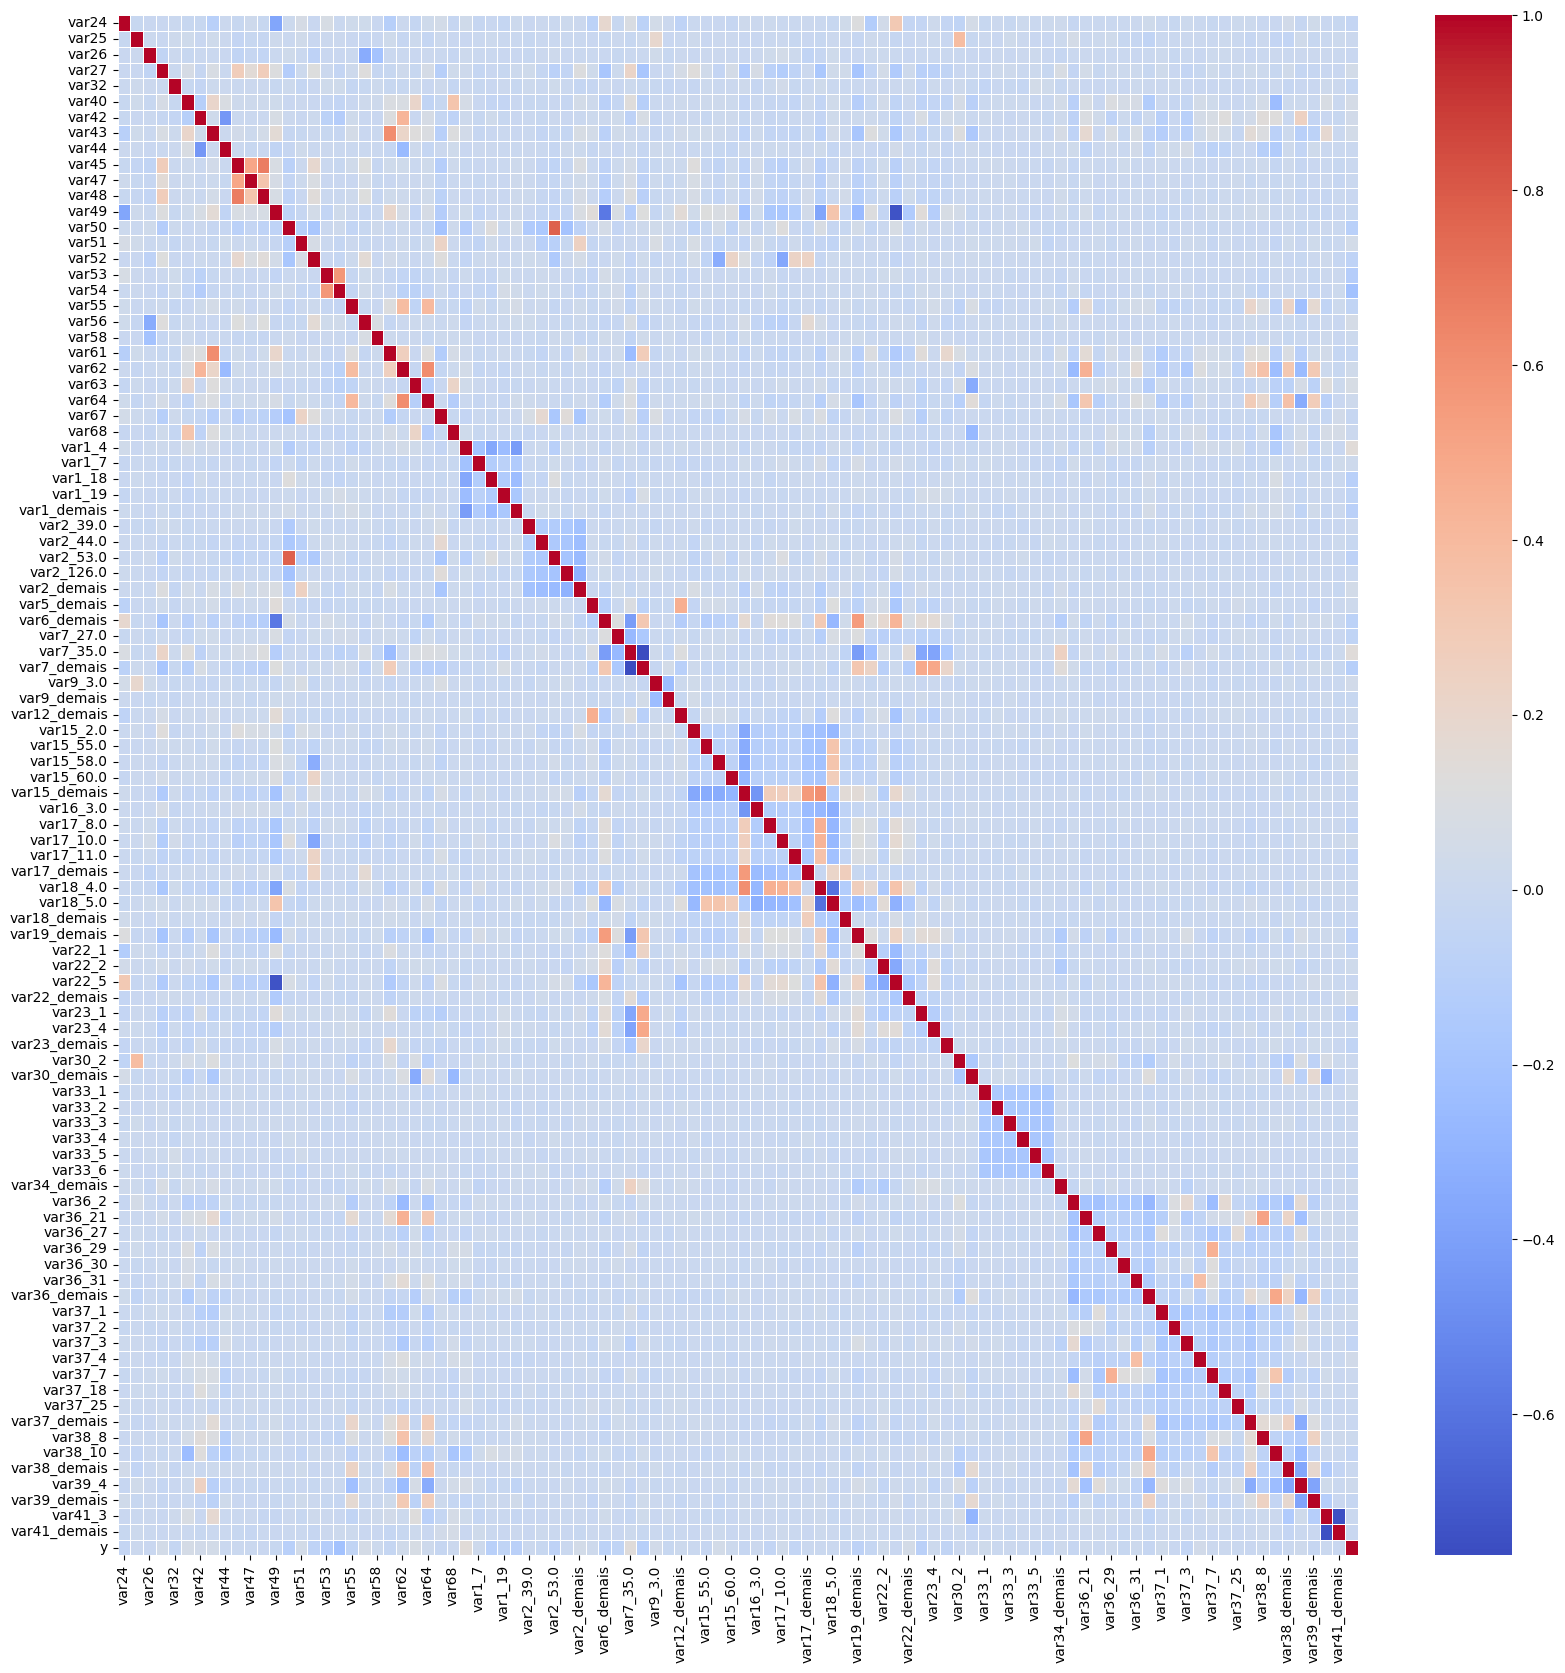

In [8]:
# Eliminação de features redundantes:
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
# Colunas com correlação acima de 80% serão removidas
redundant_features = [column for column in upper_triangle.columns if any(upper_triangle[column].abs() > 0.8)]
dataset = dataset.drop(columns=redundant_features)
print(f"Features removidas devido à alta correlação: {redundant_features}")

correlation_matrix = dataset.corr()
# Mapa de calor da correlação
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

## Modelo de Regressão Logística

### Desenvolvimento de rotinas para avaliação de cada modelo

In [9]:
def plot_roc_curve(tprs):
    plt.figure(figsize=(6,4))
    base_fpr = np.linspace(0, 1, 101)
    for tpr in tprs:
        plt.plot(base_fpr, tpr, 'b', alpha=0.15)
    # Mean and Std 
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)
    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std

    # Plot mean ROC curve and also the variance around it to build confidence intervals
    plt.plot(base_fpr, mean_tprs, 'b')
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title("ROC Curve")
    plt.show()

In [10]:
def plot_confusion_matrix(actual_classes : np.array, predicted_classes : np.array, sorted_labels : list):
    matrix = confusion_matrix(actual_classes, predicted_classes, labels=sorted_labels)
    plt.figure(figsize=(7,4))
    sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="BuPu", fmt="g")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
    plt.show()

### Avaliação utilizando validação cruzada

Accuracy (fold 1): 0.7807
Accuracy (fold 2): 0.7827
Accuracy (fold 3): 0.7906
Accuracy (fold 4): 0.7758
Accuracy (fold 5): 0.7650
Accuracy (fold 6): 0.7807
Accuracy (fold 7): 0.7648
Accuracy (fold 8): 0.7687
Accuracy (fold 9): 0.7766
Accuracy (fold 10): 0.7589

Mean Accuracy: 0.7744+/-0.0093
Mean Precision: 0.5390+/-0.0348
Mean Recall: 0.1790+/-0.0152
Mean AUC: 0.7351 +/- 0.0181


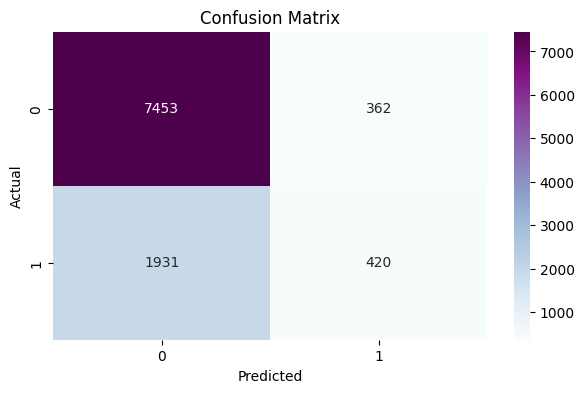

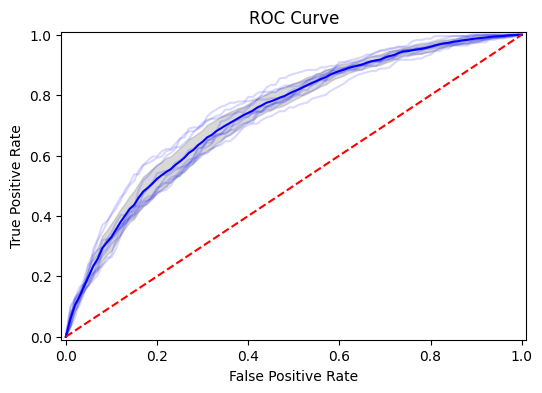

In [11]:
def apply_cross_validation(X, y, model, params={}, cv =10, scale=False):
    k_fold = KFold(n_splits=cv, shuffle=True, random_state=1)
    predicted_classes = []
    pred_proba = []
    real_classes = []
    accuracy = np.zeros(cv)
    precision = np.zeros(cv)
    recall = np.zeros(cv)
    auc = np.zeros(cv)
    tprs = []
    base_fpr = np.linspace(0, 1, 101)
    idx = 0
    for train_indices, test_indices in KFold(n_splits=10, shuffle=True, random_state=10).split(X):
        X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
        y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
        if scale:
            normalizer = MinMaxScaler()
            X_train = normalizer.fit_transform(X[train_indices])
            X_test = normalizer.transform(X[test_indices])
        clf = model(**params)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1]  # Probabilidade de classe 1
        predicted_classes = np.append(predicted_classes, y_pred)
        real_classes = np.append(real_classes, y_test)
        #calculating accuracy, precision and reall
        precision[idx] = precision_score(y_test, y_pred)
        recall[idx] = recall_score(y_test, y_pred)
        accuracy[idx] = accuracy_score(y_test, y_pred)
        auc[idx] = roc_auc_score(y_test, y_prob)
        y_score = clf.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
        pred_proba = np.append(pred_proba, y_score[:, 1])
        idx +=1
        print(f'Accuracy (fold {idx}): ' + '{:.4f}'.format(accuracy_score(y_test, y_pred))) 
 
    print(f"\nMean Accuracy: " + '{:.4f}'.format(accuracy.mean()) + "+/-" + '{:.4f}'.format(accuracy.std())) 
    print(f"Mean Precision: " + '{:.4f}'.format(precision.mean()) + "+/-" + '{:.4f}'.format(precision.std())) 
    print(f"Mean Recall: " + '{:.4f}'.format(recall.mean()) + "+/-" + '{:.4f}'.format(recall.std()))
    print(f"Mean AUC: {round(np.mean(auc), 4)} +/- {round(np.std(auc), 4)}") 
    plot_confusion_matrix(real_classes, predicted_classes, [0, 1])
    plot_roc_curve(np.array(tprs))
    pr_curve = precision_recall_curve(real_classes, pred_proba)


clf = LogisticRegression
params = {'max_iter' : 10000, 'fit_intercept' : True}
# Validação cruzada
X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1]
apply_cross_validation(X, y, clf, params)

In [12]:
class myLogisticRegression:
    def __init__(self, learning_rate=0.01, epochs=1000, tolerance=1e-6):
        self.learning_rate = learning_rate  
        self.epochs = epochs  
        self.weights = None  
        self.bias = 0  
        self.tolerance = tolerance 

    # Função Sigmoid
    def sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))

    # Função de Custo Log-Loss
    def compute_cost(self, y, y_pred):
        m = len(y)
        cost = -(1/m) * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
        return cost

    # Função de Treinamento utilizando Gradiente Descendente
    def fit(self, X, y):
        m, n = X.shape  
        self.weights = np.zeros(n)  # Pesos inicializados com zero
        prev_cost = float('inf')
        for epoch in range(self.epochs):
            # 1. Predição do modelo com os pesos atuais:
            y_pred = self.sigmoid(np.dot(X, self.weights) + self.bias)

            # 2. Calcular o custo (log-loss)
            cost = self.compute_cost(y, y_pred)

            # 3. Verificar a convergência
            if abs(prev_cost - cost) < self.tolerance:
                print(f"Critério de parada atingido na iteração {epoch}. Custo: {cost:.4f}")
                break

            # 4. Gradiente descendente: calcular os gradientes
            dw = (1/m) * np.dot(X.T, (y_pred - y))  # Gradiente dos pesos
            db = (1/m) * np.sum(y_pred - y)  # Gradiente do viés

            # 5. Atualizar os parâmetros (pesos e viés)
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # Atualização do custo anterior
            prev_cost = cost  

    # Função de Previsão
    def predict(self, X):
        y_pred = self.sigmoid(np.dot(X, self.weights) + self.bias)
        return y_pred >= 0.5  

    # Função de Previsão que retorna probabilidades
    def predict_proba(self, X):
        y_prob = self.sigmoid(np.dot(X, self.weights) + self.bias)
        return np.vstack([1 - y_prob, y_prob]).T 

Accuracy (fold 1): 0.7778
Accuracy (fold 2): 0.7856
Accuracy (fold 3): 0.7866
Accuracy (fold 4): 0.7699
Accuracy (fold 5): 0.7601
Accuracy (fold 6): 0.7660
Accuracy (fold 7): 0.7687
Accuracy (fold 8): 0.7697
Accuracy (fold 9): 0.7677
Accuracy (fold 10): 0.7451

Mean Accuracy: 0.7697+/-0.0115
Mean Precision: 0.5074+/-0.0316
Mean Recall: 0.1864+/-0.0162
Mean AUC: 0.6968 +/- 0.021


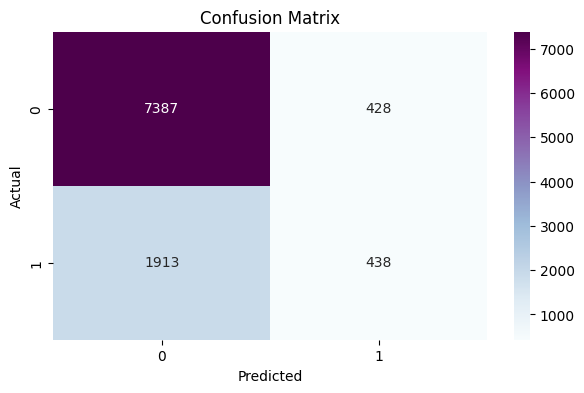

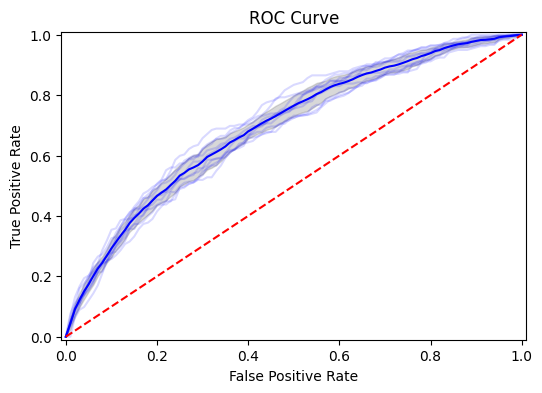

In [16]:
clf = myLogisticRegression
# Validação cruzada
X = dataset.iloc[:,:-1].astype(float)
y = dataset.iloc[:,-1].astype(float)
apply_cross_validation(X, y, clf)

Tanto o modelo criado utilizando a biblioteca sckit-learning quanto o modelo desenvolvido apresentaram acurácia pŕoxima de 77% e AUC de aproximadamente 70%. A princípio isso pode parecer um bom resultado, porém por se tratar de um *dataset* desbalanceado é necessário um olhar mais atento a performance do modelo em classificar cada classe.

Ao observar as matrizes de confusão dos modelos pode-se notar que:

- O modelo tem excelente desempenho para a classe zero, com alta acurácia (pŕoxima de 77%) e alta especificidade (em torno de 95%).
- No entanto, ele é ruim para a classe positiva, apresentando recall muito baixo (em torno de 18%) e F1-Score de apenas 27% aproximadamente.

A disparidade entre o número de casos com classe zero (7815) e o número de casos com classe um (2351) pode estar prejudicando o modelo.
